In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import numpy as np
import pandas as pd
import prettyplotlib as ppl
#from pls_m4 import *
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern Roman'], 'size':14})
rc('text', usetex=True)

In [2]:
df_orig = pd.read_csv('final_data_files/all_possible_phot_braga_resid_sigclip_bool.csv')

In [3]:
for label in ['j', 'h', 'k', '3', '4']:
    print label, len(df_orig['mag_{}'.format(label)][~df_orig['clip_{}'.format(label)]])

j 139
h 121
k 130
3 52
4 41


In [4]:
bad_ids = [127]  #[103, 107]#, 40, 169]#, 169] #120, , 357
# df_bad = df_orig[df_orig.id.isin(bad_ids)]
# df_bad_ab = df_bad[df_bad.type == 0]
# df_bad_c = df_bad[df_bad.type == 1]

df = df_orig[~df_orig.id.isin(bad_ids)]

In [5]:
# things for plotting loop
#funcs = [j_ab, j_c, h_ab, h_c, k_ab, k_c, t_ab, t_c, f_ab, f_c]
band_labels = ['j', 'h', 'k', '3', '4']
band_names = ['J', 'H', 'K_s', '[3.6]', '[4.5]']
cmap = plt.cm.get_cmap('gist_rainbow')
plot_colors = list(reversed([cmap(i) for i in np.linspace(0,0.91,len(band_labels))]))
mag_offset = [8,6,4,2,0]
wavelength = [1.220, 1.630, 2.190, 3.550, 4.493]

In [6]:
# select only the rows with photometry for all bands
df1 = df #[(np.isfinite(df.mag_j)) & (np.isfinite(df.mag_h)) & (np.isfinite(df.mag_k)) &
        #((np.isfinite(df.mag_3)) | (np.isfinite(df.mag_4)))]

In [7]:
p0_ab = np.mean(np.log10(df.per_new[df.type == 0]))
print p0_ab
p0_c = np.mean(np.log10(df.per_new[df.type == 1]))
print p0_c

-0.186553912448
-0.448672912614


In [8]:
def fitfunc_ab(x,slope,zpt):
    return zpt + slope*(x-p0_ab)
def fitfunc_c(x,slope,zpt):
    return zpt + slope*(x-p0_c)

J ab -2.08458354191 0.114408799201 13.4302799995 0.00829239136015 0.0630289571687
J c -2.11903876062 0.12893865324 13.6406987993 0.00769589683016 0.0630289571687
H ab -2.26926584007 0.160012187278 13.1755338315 0.0116583066504 0.0864510148963
H c -2.43954975642 0.18386510959 13.473539483 0.0112281714026 0.0864510148963
K_s ab -2.38834948096 0.10963007166 13.0973633754 0.00796361041942 0.0595884350264
K_s c -2.45381007076 0.13454797991 13.4014481575 0.00810203518088 0.0595884350264
[3.6] ab -2.24696404542 0.231314801916 13.1239071495 0.0171378367936 0.08994354808
[3.6] c -3.05816219576 0.31553622758 13.4863206942 0.0215317587228 0.08994354808
[4.5] ab -2.60496453762 0.557702588809 13.1729430716 0.0405308481304 0.180724865947
[4.5] c -2.18262659054 0.778799735562 13.4481661839 0.0453601793224 0.180724865947


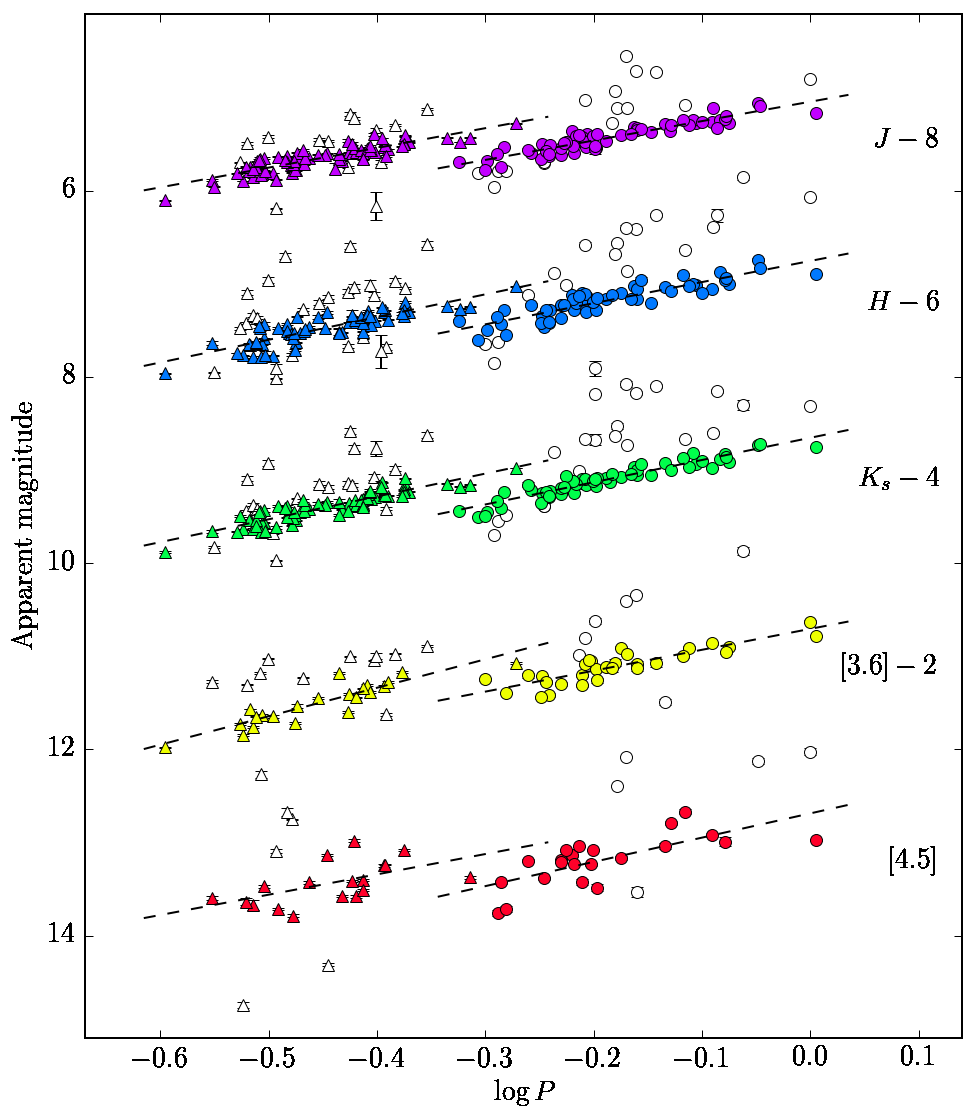

In [15]:
fig = plt.figure(figsize=(7,8))
ax = fig.add_subplot(1,1,1)
ax.set_ylim(15.1, 4.1)
ax.set_xlim(-0.67, 0.14)

# separate full and cut sample dataframes into abs and cs
df_ab = df[df.type == 0]
df_c = df[df.type == 1]

df1_ab = df1[df1.type == 0]
df1_c = df1[df1.type == 1]

slope_prior = -2.
zpt_prior = 14
#feh = -1.56749344383

per_ab_0 = np.log10(df1_ab.per_new)
per_c_0 = np.log10(df1_c.per_new)
xspace_ab = np.linspace(np.min(per_ab_0) - 0.02, np.max(per_ab_0) + 0.03, 100)
xspace_c = np.linspace(np.min(per_c_0) - 0.02, np.max(per_c_0) + 0.03, 100)

params_df = {}
params_df['wavelength'] = wavelength
params_df['slope_ab'] = []
params_df['slope_c'] = []
params_df['slope_err_ab'] = []
params_df['slope_err_c'] = []
params_df['zpt_ab'] = []
params_df['zpt_c'] = []
params_df['zpt_err_ab'] = []
params_df['zpt_err_c'] = []
params_df['sig_ab'] = []
params_df['sig_c'] = []

for i in range(len(band_labels)):
    l = band_labels[i]
    mag_ab = df1_ab['mag_' + l][~df1_ab['clip_' + l]]
    merr_ab = df1_ab['merr_' + l][~df1_ab['clip_' + l]]
    mag_c = df1_c['mag_' + l][~df1_c['clip_' + l]]
    merr_c = df1_c['merr_' + l][~df1_c['clip_' + l]]
    per_ab = per_ab_0[~df1_ab['clip_' + l]]
    per_c = per_c_0[~df1_c['clip_' + l]]

    mag_ab_clip = df1_ab['mag_' + l][df1_ab['clip_' + l]]
    merr_ab_clip = df1_ab['merr_' + l][df1_ab['clip_' + l]]
    mag_c_clip = df1_c['mag_' + l][df1_c['clip_' + l]]
    merr_c_clip = df1_c['merr_' + l][df1_c['clip_' + l]]
    per_ab_clip = per_ab_0[df1_ab['clip_' + l]]
    per_c_clip = per_c_0[df1_c['clip_' + l]]

    # do the fitting
    popt_ab, pcov_ab = curve_fit(fitfunc_ab, per_ab, mag_ab, p0 = [slope_prior, zpt_prior])
    popt_c, pcov_c = curve_fit(fitfunc_c, per_c, mag_c, p0 = [slope_prior, zpt_prior])
    slope_ab, slope_err_ab = popt_ab[0], np.sqrt(np.diag(pcov_ab))[0]
    zpt_ab, zpt_err_ab = popt_ab[1], np.sqrt(np.diag(pcov_ab))[1]
    slope_c, slope_err_c = popt_c[0], np.sqrt(np.diag(pcov_c))[0]
    zpt_c, zpt_err_c = popt_c[1], np.sqrt(np.diag(pcov_c))[1]
    
    params_df['slope_ab'].append(slope_ab)
    params_df['slope_err_ab'].append(slope_err_ab)
    params_df['zpt_ab'].append(zpt_ab)
    params_df['zpt_err_ab'].append(zpt_err_ab)
    params_df['slope_c'].append(slope_c)
    params_df['slope_err_c'].append(slope_err_c)
    params_df['zpt_c'].append(zpt_c)
    params_df['zpt_err_c'].append(zpt_err_c)
            
    # fit lines for plotting + get residuals
    linfit_ab = fitfunc_ab(xspace_ab, slope_ab, zpt_ab)
    linfit_c = fitfunc_c(xspace_c, slope_c, zpt_c)
    
    # get all residuals and update dataframe with them
    df_ab_filter = df_orig[np.isfinite(df_orig['mag_' + l]) & (df_orig.type == 0)]
    df_c_filter = df_orig[np.isfinite(df_orig['mag_' + l]) & (df_orig.type == 1)]
    resid_ab = df_ab_filter['mag_' + l] - fitfunc_ab(np.log10(df_ab_filter.per_new), slope_ab, zpt_ab)
    resid_c = df_c_filter['mag_' + l] - fitfunc_c(np.log10(df_c_filter.per_new), slope_c, zpt_c)
    df_orig['resid_' + l].update(resid_ab)
    df_orig['resid_' + l].update(resid_c)
    resid_fit_ab = np.std(mag_ab - fitfunc_ab(per_ab, slope_ab, zpt_ab))
    resid_fit_c = np.std(mag_c - fitfunc_c(per_c, slope_c, zpt_c))
    params_df['sig_ab'].append(resid_fit_ab)
    params_df['sig_c'].append(resid_fit_c)
    
    print band_names[i], 'ab', slope_ab, slope_err_ab, zpt_ab, zpt_err_ab, resid_fit_ab
    print band_names[i], 'c', slope_c, slope_err_c, zpt_c, zpt_err_c, resid_fit_ab
    #print np.mean(resid_ab), np.median(resid_ab), np.mean(resid_c), np.median(resid_c)
    
    # plot full sample in grey
#     plt.errorbar(np.log10(df_ab.per_new), df_ab['mag_' + l] - mag_offset[i],
#                  yerr=df_ab['merr_' + l].values, fmt='o', color='#AAAAAA',
#                  mec='#AAAAAA', zorder=-1)
#     plt.errorbar(np.log10(df_c.per_new), df_c['mag_' + l] - mag_offset[i],
#                  yerr=df_c['merr_' + l].values, fmt='^', color='#AAAAAA',
#                  mec='#AAAAAA', zorder=-1)

    #err_wtf = df_bad_ab['merr_' + l].values
                     
    plt.errorbar(per_ab_clip.values, mag_ab_clip.values - mag_offset[i], yerr=merr_ab_clip.values,
                 fmt='o', color='k', mfc='w')
    plt.errorbar(per_c_clip.values, mag_c_clip.values - mag_offset[i], yerr=merr_c_clip.values,
                 fmt='^', color='k', mfc='w')
    
    # plot cut sample in color
    plt.errorbar(per_ab.values, mag_ab.values - mag_offset[i], yerr=merr_ab.values, fmt='o',
                 mfc=plot_colors[i], color='k')
    plt.errorbar(per_c.values, mag_c.values - mag_offset[i], yerr=merr_c.values,
                 fmt='^', mfc=plot_colors[i], color='k')
        
    ppl.plot(xspace_ab, linfit_ab - mag_offset[i], 'k--', lw=1)
    ppl.plot(xspace_c, linfit_c - mag_offset[i], 'k--', lw=1)
    
    # add labels
    if mag_offset[i] == 0:
        plt.text(ax.get_xlim()[1] - 0.02, np.median(mag_ab - mag_offset[i] + 0.1),
                 '${}$'.format(band_names[i]), ha='right')
    else:
        plt.text(ax.get_xlim()[1] - 0.02, np.median(mag_ab - mag_offset[i] + 0.1),
                 '${} - {}$'.format(band_names[i], mag_offset[i]), ha='right')

        
# df_81 = df_orig[df_orig.id==81]
# herp = df_81.filter(regex='mag').values - mag_offset
# derp = np.log10(df_81.per_new.values.repeat(5))
# #print herp[0], derp
# plt.errorbar(derp, herp[0], fmt='o', color='k')

ax.set_ylabel('Apparent magnitude')
ax.set_xlabel(r'$\log P$')
fig.tight_layout()
fig.savefig('final_plots/omegacen_pl_fits_sigclip.pdf')

In [10]:
params_df = pd.DataFrame.from_dict(params_df)
params_df = params_df[['wavelength','slope_ab','slope_err_ab','zpt_ab','zpt_err_ab','sig_ab',
                           'slope_c','slope_err_c','zpt_c','zpt_err_c','sig_c']]
params_df.to_csv('final_data_files/omegacen_fit_params_sigclip.csv', index=False)

In [11]:
df_orig.to_csv('final_data_files/all_possible_phot_braga_resid_sigclip.csv',index=False)